# Private Investor Generation Expansion Planning

- Universidad Pontificia Comillas
- Master's Degree in the Electric Power Industry (MEPI)
- Diego Alejandro Tejada Arango

In [ ]:
!pip install pyomo
!pip install highspy
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [2]:
# Import necessary libraries
import pyomo.environ as pyo
import pandas as pd
import highspy

In [3]:
# Load input data files
input_folder = "./inputs/"

df_prices   = pd.read_csv(input_folder + "dayahead_price_forecast.csv")
df_profiles = pd.read_csv(input_folder + "solar_pv_spain_uncorrected.csv",skiprows=3)
df_demand   = pd.read_csv(input_folder + "electricity_demand_profile_household_spain.csv")

In [4]:
# Define model
model = pyo.ConcreteModel()

# Define sets based on data (example: years, hours, etc.)
H = df_prices.Period.unique()
Y = df_prices.Year.unique()
model.Y = pyo.Set(initialize=Y)  # Year set
model.H = pyo.Set(initialize=H)  # Hour set

In [5]:
# Define parameters
p_max_consumption = 4.5   # kW (maximum contracted power)
p_unit_capacity   = 0.25  # kW (capacity of each unit)
p_demand_growth   = 0.002 # p.u.
p_WACC            = 0.05  # Weighted Average Cost of Capital
p_tax_to_sells    = 0.05  # p.u.
p_investment_cost = 0.32  # kEUR/kW
p_fix_om_cost     = 0.05  # kEUR/year

In [6]:
# Read time series from the dataframes
p_demand     = {row.Hour_of_Year+1: row.Profile_Value for _, row in df_demand.iterrows()}
p_year_order = {year: idx + 1 for idx, year in enumerate(Y)}
p_price      = {(row.Year, row.Period): row.Price for _, row in df_prices.iterrows()}
p_profile    = {idx + 1: row.electricity for idx, row in df_profiles.iterrows()}

In [7]:
# Define decision variables
model.v_production = pyo.Var(model.Y, model.H, bounds=(0, p_max_consumption))
model.v_purchasing = pyo.Var(model.Y, model.H, bounds=(0, p_max_consumption))
model.v_selling    = pyo.Var(model.Y, model.H, bounds=(0, p_max_consumption))
model.v_investment = pyo.Var(bounds=(0, p_max_consumption / p_unit_capacity / 2))

In [8]:
# Define expressions
def demand_expr(model, y, h):
    return p_demand[h] * p_max_consumption * (1 + p_demand_growth) ** (p_year_order[y] - 1)
model.e_demand = pyo.Expression(model.Y, model.H, rule=demand_expr)

model.e_savings = pyo.Expression(
    expr=sum((p_price[y, h] / 1000) * model.v_production[y, h] / (1 + p_WACC) ** p_year_order[y] for y in model.Y for h in model.H)
)

model.e_taxes = pyo.Expression(
    expr=sum((p_price[y, h] / 1000) * p_tax_to_sells * model.v_selling[y, h] / (1 + p_WACC) ** p_year_order[y] for y in model.Y for h in model.H)
)

In [9]:
# Investment and maintenance cost expressions
model.e_investment_cost = pyo.Expression(expr=1000 * p_investment_cost * p_unit_capacity * model.v_investment)
model.e_fix_om_cost = pyo.Expression(expr=1000 * p_fix_om_cost * model.v_investment)

# Define the objective function
model.objective = pyo.Objective(
    expr=model.e_savings - model.e_taxes - model.e_investment_cost - model.e_fix_om_cost,
    sense=pyo.maximize
)

In [10]:
# Define constraints
def max_prod_constraint(model, y, h):
    return model.v_production[y, h] == p_profile[h]*p_unit_capacity*model.v_investment
model.c_max_prod = pyo.Constraint(model.Y, model.H, rule=max_prod_constraint)

# Define balance constraint as an example (adjust accordingly)
def balance_constraint(model, y, h):
    return model.v_production[y, h] + model.v_purchasing[y, h] == model.v_selling[y, h] + model.e_demand[y, h]
model.c_balance = pyo.Constraint(model.Y, model.H, rule=balance_constraint)

In [11]:
# Solve the model
solver = pyo.SolverFactory('appsi_highs') 
results = solver.solve(model, tee=True)

Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [3e-04, 1e+00]
  Cost   [5e-05, 1e+02]
  Bound  [4e+00, 9e+00]
  RHS    [1e+00, 4e+00]
Presolving model
44540 rows, 52734 cols, 97273 nonzeros  0s
8193 rows, 16387 cols, 24579 nonzeros  0s
Presolve : Reductions: rows 8193(-167007); columns 16387(-246414); elements 24579(-370361)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
       8236    -1.5071012906e+01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 8236
Objective value     :  1.5071012906e+01
Relative P-D gap    :  7.1073071256e-14
HiGHS run time      :          0.47


In [12]:
# Display objective function and investment decision
print("Objective value:", pyo.value(model.objective))
print("Investment:", pyo.value(model.v_investment))

Objective value: 15.07101290583472
Investment: 8.780487804878048


In [13]:
# store the results in a dataframe
results_df = pd.DataFrame(index=Y, columns=H)
for y in model.Y:
    for h in model.H:
        results_df.loc[y, h] = pyo.value(model.v_production[y, h])

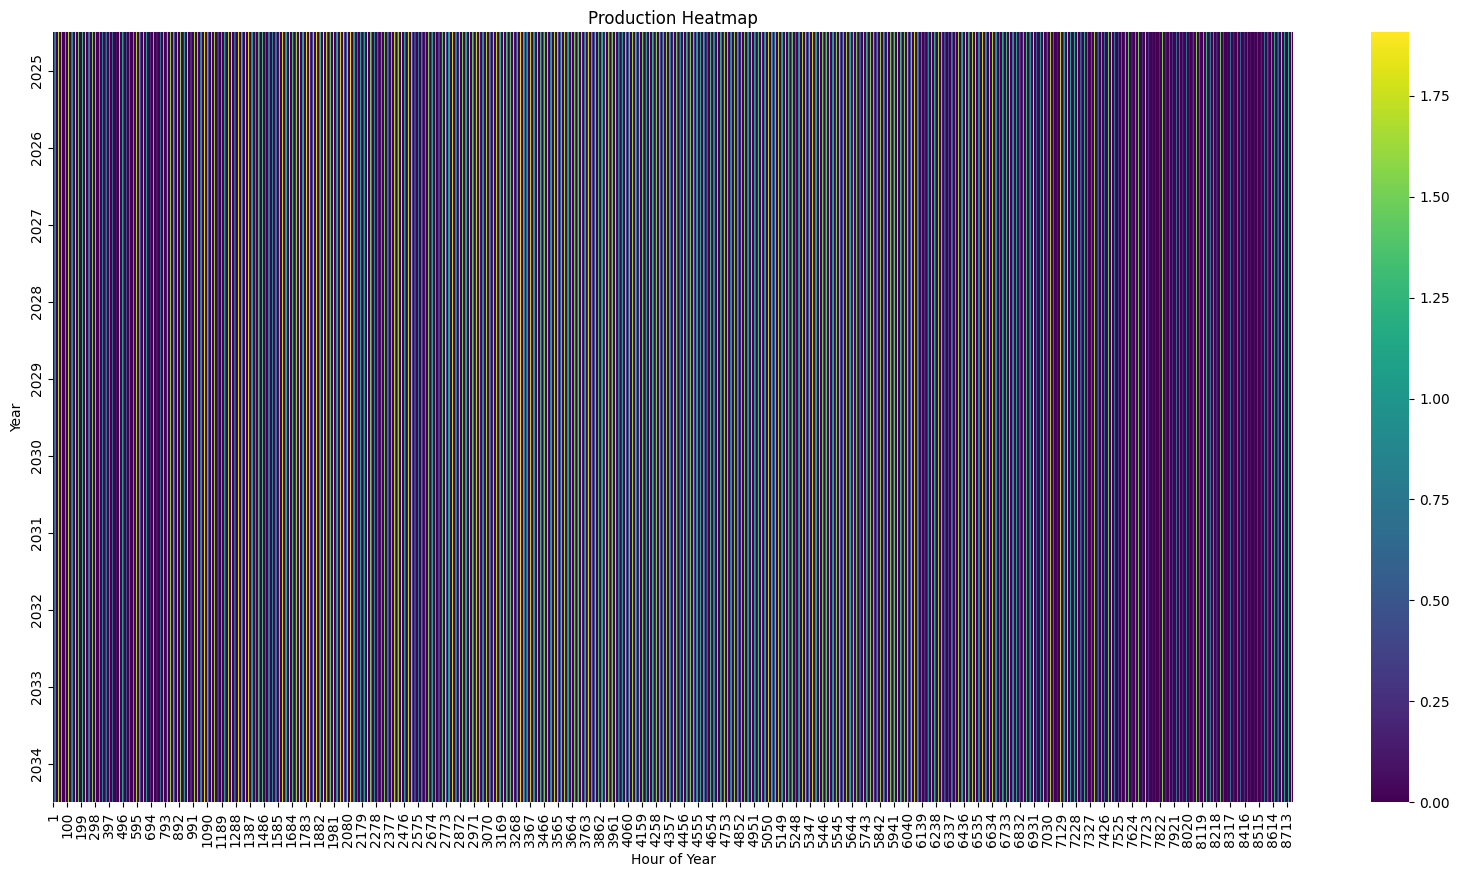

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(results_df.astype(float), cmap='viridis')
plt.title('Production Heatmap')
plt.xlabel('Hour of Year')
plt.ylabel('Year')
plt.show()